# My baseline 

In [1]:
import glob
import os
from tqdm.auto import tqdm
from multiprocessing import Pool, cpu_count
import cv2
import time
import argparse
import logging
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import timm
from timm.models import create_model, apply_test_time_pool
from timm.data import ImageDataset, create_loader, resolve_data_config
from timm.utils import AverageMeter, setup_default_logging

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Scoring function

In [3]:
# copy from https://www.kaggle.com/code/ryanholbrook/competition-metric-dfl-event-detection-ap

import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal
from typing import Dict, Tuple

tolerances = {
    "challenge": [0.3, 0.4, 0.5, 0.6, 0.7],
    "play": [0.15, 0.20, 0.25, 0.30, 0.35],
    "throwin": [0.15, 0.20, 0.25, 0.30, 0.35],
}

def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, 'time'].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.        
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x video evaluation group."""
    detections_sorted = detections.sort_values('score', ascending=False).dropna()

    is_matched = np.full_like(detections_sorted['event'], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(det.time - gt.time)
            if error < best_error and not gt in gts_matched:
                best_gt = gt
                best_error = error
            
        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]
    
    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]
    
    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]
    
    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches
    
    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, float],
) -> float:

    assert_index_equal(solution.columns, pd.Index(['video_id', 'time', 'event']))
    assert_index_equal(submission.columns, pd.Index(['video_id', 'time', 'event', 'score']))

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values(['video_id', 'time'])
    submission = submission.sort_values(['video_id', 'time'])
    
    # Extract scoring intervals.
    intervals = (
        solution
        .query("event in ['start', 'end']")
        .assign(interval=lambda x: x.groupby(['video_id', 'event']).cumcount())
        .pivot(index='interval', columns=['video_id', 'event'], values='time')
        .stack('video_id')
        .swaplevel()
        .sort_index()
        .loc[:, ['start', 'end']]
        .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
    )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts('event').to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    detections_filtered = []
    for (det_group, dets), (int_group, ints) in zip(
        detections.groupby('video_id'), intervals.groupby('video_id')
    ):
        assert det_group == int_group
        detections_filtered.append(filter_detections(dets, ints))
    detections_filtered = pd.concat(detections_filtered, ignore_index=True)

    # Create table of event-class x tolerance x video_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths['video_id'].unique()],
        columns=['event', 'tolerance', 'video_id'],
    )

    # Create match evaluation groups: event-class x tolerance x video_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)
    
    # Compute AP per event x tolerance group
    event_classes = ground_truths['event'].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby(['event', 'tolerance']).apply(
        lambda group: average_precision_score(
        group['matched'].to_numpy(),
                group['score'].to_numpy(),
                class_counts[group['event'].iat[0]],
            )
        )
    )

    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby('event').mean().mean()

    return mean_ap

# post process function

In [4]:
event_names = ['challenge', 'throwin', 'play']
label_dict = {
    'background':0,
    'challenge':1,
    'play':1,
    'throwin':1,
}
event_names_with_background = ['background','challenge','play','throwin']

def make_sub(prob, pred_df):
    
    frame_rate = 25
    window_size = 10
    ignore_width = 10
    group_count = 5

    df = pd.DataFrame(prob,columns=event_names_with_background)
    df['video_id'] = pred_df['video_id']
    df['frame_id'] = pred_df['time']*frame_rate

    train_df = pd.DataFrame()
    for video_id, each_video_df in df.groupby('video_id'):
        for i, event in enumerate(event_names):
            # イベント毎にwindow size分の移動平均を取る-> prob_arrに格納(最初と最後のwindow_sizeがたりない分はNanになるので-100で埋める)
            prob_arr = each_video_df[event].rolling(window=window_size, center=True).mean().fillna(-100).values
            each_video_df['rolling_prob'] = prob_arr
            
            sort_arr = np.argsort(-prob_arr)# 全frameの中で、そのフレームのlogitsが何番目に小さいかの順番を格納したarrayを作成
            rank_arr = np.empty_like(sort_arr) # sort_arrと同じshapeの空の配列を作成(実際は空というものはないのでランダムな値が入っている)
            rank_arr[sort_arr] = np.arange(len(sort_arr)) # 各フレームのlogitsが全フレームのうち何番目に小さいかの順番を格納?
            # index list for detected action
            idx_list = []
            for i in range(len(prob_arr)):
                this_idx = sort_arr[i]
                if this_idx >= 0:
                    # Add maximam index to index_list
                    idx_list.append(this_idx)
                    # parityを組んで、こingnorelistを作って、順番が一定以下のものはpredictからはずす(probが高いところの周辺は最高値を残して消えていく)
                    for parity in (-1,1):
                        # 除外対象を考えるために、-1~1のparityに無視する範囲をかけてex_idxを作る
                        for j in range(1, ignore_width+1):
                            ex_idx = this_idx + j * parity
                            # idxがprobの長さ以内にあるときに処理する
                            if ex_idx >= 0 and ex_idx < len(prob_arr):
                                # Exclude frames near this_idx where the action occurred. 
                                sort_arr[rank_arr[ex_idx]] = -1
            this_df = each_video_df.iloc[idx_list].reset_index(drop=True).reset_index().rename(columns={'index':'rank'})[['rank','video_id','frame_id']]
            this_df['event'] = event
            train_df = train_df.append(this_df)  
    
    train_df['time'] = train_df['frame_id']/frame_rate
    train_df['score'] = 1/(train_df['rank']+1)# rankに応じてスコアをつける検出個数が多いほど後ろのscoreは小さくなっていく
    
    return train_df

# Configurations

In [5]:
DEBUG = False

In [6]:
class CFG:
    EXP = "eff_b5_ap_bce_flowimage_1output"
    # model
    model_type =  "tf_efficientnet_b5_ap"
    trained_model_path = "/workdir/work/output/eff_b5_ap_bce_flowimage_1output/effnet_b5_ap_224_1output.pth"
    out_features = 1 # output class
    inp_channels = 3 #RGB -> 3
    dropout = 0
    pretrained = False
    
    IMG_SIZE = (224, 224)


    # optical flow settings
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    crop_range = 600
    area_thr = 0.1
    FLOW_CAL_TIME = 1.0

In [7]:
event_decoding = {
    0 : "background",
    1 : "challenge",
    1 : "play",
    1 : "throwin",
}

# optical flow functions

In [8]:
def get_maxflow_area(x, y, width, height, crop_range=CFG.crop_range):
    crop_x_min = int(x) - (crop_range/2)
    crop_x_max = int(x) + (crop_range/2)
    crop_x_min = max(0, crop_x_min)
    crop_x_max = min(width, crop_x_max)

    crop_y_min = int(y) - (crop_range/2)
    crop_y_max = int(y) + (crop_range/2)
    crop_y_min = max(0, crop_y_min)
    crop_y_max = min(height, crop_y_max)

    return int(crop_x_min), int(crop_x_max), int(crop_y_min), int(crop_y_max)

In [9]:
def get_green_area(img):
    # HSV
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # creat green mask (H value for green is from 100/360*179 until 180/360*179) in OpenCV
    lower_green = np.array([100 / 360 * 179, 0, 0])
    upper_green = np.array([180 / 360 * 179, 255, 255])
    green_mask = cv2.inRange(img_HSV, lower_green, upper_green)

    # crop green area
    img_green_masked = cv2.bitwise_and(img, img, mask=green_mask)
    img_green_masked = cv2.cvtColor(img_green_masked, cv2.COLOR_BGR2GRAY)

    # Find contours
    contours, hierarchy = cv2.findContours(img_green_masked, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return int(img.shape[1]*0.5), int(img.shape[0]*0.5), img.shape[1], img.shape[0]
    # Find the contour with the maximum area.
    c = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(c)

    return x, y, w, h

In [10]:
def crop_maxflow_area(cap_, base_frame_, fps_, frame_num_):
    """色相が緑っぽいエリアをフィールドとしてクロップして、optical flowを計算。1secでflowが最も大きい点を中心としてcropする。
    
    """
    # optical flow line color
    line_color = [255, 100, 0]
    # base frameでフィールドの範囲を決める。1secで大きくカメラ方向が移動するときはだめかも
    x_field, y_field, w_field, h_field = get_green_area(base_frame_)
    base_frame_ = base_frame_[y_field:y_field+h_field, x_field:x_field+w_field, :]

    # Take first frame and find corners in it
    base_gray = cv2.cvtColor(base_frame_, cv2.COLOR_BGR2GRAY)
    base_point = cv2.goodFeaturesToTrack(base_gray, mask = None, **CFG.feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(base_frame_)

    # draw the tracks
    max_distance = 0
    img_max_dist = base_frame_

    # 1secで基準画像とのoptical flowが最も大きい点を残す
    for i in range(int(fps_*CFG.FLOW_CAL_TIME)):
        successed, relative_frame = cap_.read()
        if not successed:
            break
        frame_num_ += 1

        relative_frame = relative_frame[y_field : y_field+h_field, x_field : x_field+w_field, :]
        relative_gray = cv2.cvtColor(relative_frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        relative_point, st, err = cv2.calcOpticalFlowPyrLK(base_gray, relative_gray, base_point, None, **CFG.lk_params)

        # Select good points
        good_new = relative_point[st==1]
        good_old = base_point[st==1]

        x_max_distance = int(x_field + (w_field*0.5))
        y_max_distance = int(y_field + (h_field*0.5))
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            x_after, y_after = new.ravel()
            x_before, y_before = old.ravel()
            distance = np.sqrt( (x_after - x_before)**2 + (y_after - y_before)**2 )

            # distanceが大きい、かつ、検出点が画像の外側area_thr%にないときに移動距離が最大と判定する
            if distance > max_distance and (w_field*CFG.area_thr < x_after < w_field*(1.0 -CFG.area_thr)) and (h_field*CFG.area_thr < y_after < y_field*(1.0 - CFG.area_thr)):
                max_distance = distance
                x_max_distance = x_after
                y_max_distance = y_after
                # 画像にoptical flow の線を追加する(本当はtop5だけ描くとかの方がいいかも？)
                mask = cv2.line(mask, (int(x_after),int(y_after)), (int(x_before), int(y_before)), line_color, 2)
                relative_frame = cv2.line(relative_frame, (int(x_after),int(y_after)), (int(x_before), int(y_before)), line_color, 2)
                img_max_dist = cv2.circle(relative_frame, (int(x_after),int(y_after)), 5, line_color, -1)

    # optical flowの最も大きい点を中心にクロップ(サイズが足りないときは横方向だけとか縦方向だけの場合もあり)
    x_min, x_max, y_min, y_max = get_maxflow_area(int(x_max_distance), int(y_max_distance), w_field, h_field)
    croped_flow_image = img_max_dist[y_min:y_max, x_min:x_max, :]

    return croped_flow_image

# set inference files

In [11]:
valid_video_files = ['/workdir/work/input/train/cfbe2e94_0.mp4', '/workdir/work/input/train/cfbe2e94_1.mp4']
print(valid_video_files)

['/workdir/work/input/train/cfbe2e94_0.mp4', '/workdir/work/input/train/cfbe2e94_1.mp4']


# Load model

In [12]:
class DFLNet(nn.Module):
    def __init__(self, model_name=CFG.model_type, 
                 out_features=CFG.out_features, inp_channels=CFG.inp_channels,
                 pretrained=CFG.pretrained):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels, num_classes=out_features)
    
    def forward(self, image):
        fc = self.model(image)
        output = torch.sigmoid(fc)
        return output

In [13]:
model = DFLNet()

In [14]:
model.load_state_dict(torch.load(CFG.trained_model_path))
model.to(device)
model.eval()

DFLNet(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running

In [15]:
def image_read_formodel(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=CFG.IMG_SIZE)
    image = image / 255 # convert to 0-1
    image = image.reshape(-1, CFG.inp_channels, CFG.IMG_SIZE[0], CFG.IMG_SIZE[1])
    return torch.tensor(image, dtype=torch.float)

# Validation

In [16]:
submission_list = []
softmax = nn.Softmax(dim=1)

for video_path in valid_video_files:
    video_name = os.path.basename(video_path).split('.')[0]
    cam = cv2.VideoCapture(video_path)
    fps = cam.get(cv2.CAP_PROP_FPS)
    video_file = video_path.split("/")[-1]
    video_id = video_file.split(".")[0]
    print("video_id:", video_id)
    frame_count = 1
    preds_prob_video = []
    pred_subformat_list = []
    start_time = time.time()
    while True:
        successed, base_frame = cam.read()
        if not successed:
            break
        img = crop_maxflow_area(cam, base_frame, fps, frame_count)
        img = image_read_formodel(img)
        img = img.to(device)
        output = model(img)
        preds = output.to('cpu').detach().numpy().copy()
        preds = preds[0][0]
        # probが高くなりすぎているので適当な後処理(無いほうがスコアはまし)
        preds = (preds - 0.5)*2
        preds = max(0, preds)
        if preds > 0:
            pred_event = "play"
            frame_count = cam.get(cv2.CAP_PROP_POS_FRAMES)
            current_time = frame_count/fps
            pred_subformat_list.append([video_id, current_time, pred_event, preds])
        if DEBUG and (frame_count > 100):
            break
    if len(submission_list) == 0:
        submission_list = pred_subformat_list
    else:
        submission_list.extend(pred_subformat_list)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time:{elapsed_time}, average:{elapsed_time/60} min.")



video_id: cfbe2e94_0
Elapsed time:451.67131638526917, average:7.52785527308782 min.
video_id: cfbe2e94_1
Elapsed time:453.3849768638611, average:7.556416281064352 min.


In [17]:
valid_df = pd.DataFrame(submission_list, columns=["video_id", "time", "event", "score"])
display(valid_df.head(5))
valid_df["event"].value_counts()

,video_id,time,event,score
0,cfbe2e94_0,3.12,play,0.136205
1,cfbe2e94_0,3.64,play,0.228360
2,cfbe2e94_0,5.20,play,0.541186
3,cfbe2e94_0,7.28,play,0.774772
4,cfbe2e94_0,57.72,play,0.971865


play    1660
Name: event, dtype: int64

<AxesSubplot:>

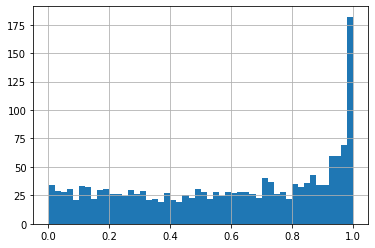

In [18]:
valid_df["score"].hist(bins=50)

In [19]:
valid_df.to_csv(f"/workdir/work/output/{CFG.EXP}/video_cap_flowimage_validation.csv", index=False)

In [20]:
valid_df["event"].value_counts()

play    1660
Name: event, dtype: int64

# validation scoring

In [21]:
solution = pd.read_csv("/workdir/work/input/train.csv", usecols=['video_id', 'time', 'event'])

In [22]:
valid_video_files

['/workdir/work/input/train/cfbe2e94_0.mp4',
 '/workdir/work/input/train/cfbe2e94_1.mp4']

In [23]:
valid_video_id = [valid_id.split("/")[-1].split(".")[0] for valid_id in valid_video_files]
print(valid_video_id)

['cfbe2e94_0', 'cfbe2e94_1']


In [24]:
solution[solution['video_id'].isin(valid_video_id)]

,video_id,time,event
8652,cfbe2e94_0,229.321518,start
8653,cfbe2e94_0,230.200000,play
8654,cfbe2e94_0,232.520000,play
8655,cfbe2e94_0,234.016200,end
8656,cfbe2e94_0,246.666301,start
...,...,...,...
10233,cfbe2e94_1,3562.660000,play
10234,cfbe2e94_1,3563.835896,end
10235,cfbe2e94_1,3572.500727,start
10236,cfbe2e94_1,3574.340000,throwin


In [25]:
score_before_pp = event_detection_ap(solution[solution['video_id'].isin(valid_video_id)], valid_df, tolerances)

In [26]:
print(score_before_pp)

0.030852682875974164


# Score(memo)

## before pp

- focalloss : 0.011592382625658445
- crossentropy : 0.005342858648023062
- bce(flow image): 0.0147564709424373

#### with crop
- bce (flow image, 3sec): 0.013892144681695594
- bce (flow image, 1sec): 0.023892144681695594
- bce (flow image, 1sec, probchage): 0.020262194957537494
- bce (flow image, 0.5 sec, probchage): 0.039299473910823224
- bce (flow image, 0.5 sec, 1output, probchage): 0.030852682875974164

## after pp

- bce (flow image) : 0.06103998460334889

#### with crop
- bce (flow image, 3sec) :  0.0019885161915018453
- bce (flow image, 3sec) :  0.01214557056162458
- bce (flow image, 1sec, probchage) : 0.005615242633485843
- bce (flow image, 0.5sec, probchage) : 0.006466410476529082